## Preface



First, if you don&rsquo;t already have the latest version of the `cfe` package
installed, grab it, along with some dependencies:



In [1]:
!pip install CFEDemands --upgrade --pre
!pip install xarray --upgrade
!pip install h5netcdf

Requirement already up-to-date: CFEDemands in /home/ethanligon/anaconda3/lib/python3.7/site-packages (0.2.6.dev0)
Requirement already up-to-date: xarray in /home/ethanligon/anaconda3/lib/python3.7/site-packages (0.15.1)


Second, load relevant dataset:



In [2]:
import cfe

# Results can be made persistent by saving them, and then re-loading...
r = cfe.from_dataset('./Indian ICRISAT_small.ds')

r['alpha'] = r.alpha.loc[r.alpha>0]  # Insist on alpha positive

/home/ethanligon/anaconda3/lib/python3.7/typing.py:845: FutureWarning: xarray subclass Result should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)


## Choosing reference prices, budget, and units



We&rsquo;ll want to choose reference prices (a choice of `t` and `m`) and
units (`u`).  You can examine possibilities by looking at:



In [3]:
r.prices.coords

Coordinates:
  * i        (i) object '2G' '4K' '5B' 'AB' 'AN' ... 'ZA' 'ZB' 'ZF' 'ZJ' 'ZK'
  * t        (t) int64 75 76 77 78 79 80 81 82 83 84
  * m        (m) object 'A' 'B' 'C' 'D' 'E' 'F'
  * u        (u) object '.' '1' '5' 'G' 'Hours' 'Hundreds' 'Kilograms'

Below we choose first market in first period, but this is a matter of
choice.  We also choose prices for goods measured in &rsquo;Kilograms&rsquo;; this
may vary with the dataset.  To inspect possible units look at:



In [4]:
t = r.firstround  # First round
m = r.coords['m'][0] # First market

# Get median budget
x = r.get_predicted_expenditures().sum('i')
medianx = x.where(x>0).sel(t=t,m=m).median('j').values

# Note selection of prices for first market in first period for /kgs/.
# For goods never measured in kgs prices will be missing. 
p = r.prices.sel(t=75,m='A',u='Kilograms',drop=True).to_dataframe().squeeze().dropna()
p

/home/ethanligon/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


i
Bajra/Pearl millet (HYV)               1.296154
Bajra/Pearl millet (Local variety)     1.279162
Bengalgram (Chenna)/Chickpea           3.164902
Bengalgram dhal                        6.855503
Blackgram (Urad)                       5.000000
Blackgram dhal                         7.329897
Bullocks                               2.500000
Castor                                 1.510760
Castor (HYV)                           3.356959
Chillies                               2.339487
Coconut                                8.837209
Coffee                                44.000000
Cosmetics tooth paste etc.            29.793103
Cowpea                                 2.000000
Edible oils                            7.590522
Fish                                   4.000000
Ghee                                  14.748448
Goat                                  13.717098
Greengram (Mung)                       3.787879
Greengram dhal                         6.514772
Groundnut oil                         

And with $(x,p)$ defined we can calculate example demands:



In [5]:
# Expenditures divided by reference prices per Kilogram
c=(r.demands(medianx)/p).dropna()
c

i
Bengalgram dhal                   3.590749
Chillies                          0.882474
Coconut                           0.509505
Cosmetics tooth paste etc.        0.414034
Gur (jaggery)                     7.723045
Jowar/Sorghum (Local variety)     3.818556
Milk                             20.508271
Other spices                     20.102816
Other vegetables                  6.431510
Redgram dhal                     22.178645
Sugar                             7.174740
Tea                               0.867074
Tobacco, beedi                    0.189597
dtype: float64

## Mapping to Nutrients



We&rsquo;ve seen how to map prices and budgets into vectors of consumption
quantities using `cfe.Result.demands`.  Next we want to think about
how to map these into bundles of *nutrients*.  The information needed
for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
such as the [USDA Food Central Database](https://fdc.nal.usda.gov/)).   Here we&rsquo;ve adapted (with
thanks to Alessandro Tarozzi of the Universitat Pompeu Fabra) a food
conversion table developed by Gopalan et al (1980) to the foods
reported in the Indian ICRISAT data:



In [6]:
import pandas as pd
import numpy as np

# The function below adapted from Gianmario Spacagna's suggestion at
# https://stackoverflow.com/questions/19611729/getting-google-spreadsheet-csv-into-a-pandas-dataframe
def dataframe_from_gspreadsheet(sheet_name, key):
    """Transform public google spreadsheet into pandas.DataFrame."""
    
    url = 'https://docs.google.com/spreadsheets/d/{key}/gviz/tq?tqx=out:csv&sheet={sheet_name}&headers=1'.format(
        key=key, sheet_name=sheet_name.replace(' ', '%20'))

    df = pd.read_csv(url)

    return df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

# Change 'ICRISAT' sheet id to that of your own sheet
fct = dataframe_from_gspreadsheet("FCT", '13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo')


# Change some labels
d={'protein':'Protein',
   'protein g':'Protein',
   'fat':'Fat',
   'energy_kcal':'Calories',
   'energy kcal':'Calories',
   'calcium':'Calcium',
   'ca mg':'Calcium',
   'betacarotene':'Betacarotene',
   'thiamine':'Thiamine',
   'riboflavin':'Riboflavin',
   'niacin':'Niacin',
   'iron':'Iron',
   'fe mg':'Iron',
   'ascorbic_total':'Ascorbic Acid',
   'vit a ug':'Vitamin A',
   'vit b6 mg':'Vitamin B6',
   'vit b12 ug':'Vitamin B12',
   'vit d ug':'Vitamin D',
   'vit e ug':'Vitamin E',
   'vit c mg':'Vitamin C',
   'mg mg':'Magnesium',
   'zn mg':'Zinc'}

fct = fct.rename(columns=d) #[list(d.values())]

# Fix capitalization (to match food labels)
fct.index = fct.reset_index()['i'].str.title()
del fct['i']
del fct['ext_source']

# Replace missing with zeros
fct = fct.fillna(0)

try:
    fct.index = fct.index.droplevel('u')
except (AttributeError,KeyError):
    pass # No units?

fct.columns

Index(['Protein', 'Fat', 'fibre', 'carbohydrate', 'Calories', 'energy_kj',
       'Calcium', 'Iron', 'Betacarotene', 'caroten_total', 'Thiamine',
       'Riboflavin', 'Niacin', 'Ascorbic Acid', 'pu_cal', 'pu_prot', 'pu_fat'],
      dtype='object')

We need the index of the Food Conversion Table (FCT) to match up with
the index of the vector of quantities demanded.   To manage this we
make use of the `align` method for `pd.DataFrames`:



In [7]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(c,axis=0,join='inner')
print(fct0.index)

Index(['Milk', 'Sugar', 'Chillies', 'Coconut', 'Tea'], dtype='object', name='i')


Now, since rows of `fct0` and `c0` match, we can obtain nutritional
outcomes from the inner (or dot, or matrix) product of the transposed
`fct0` and `c0`:



In [8]:
# The @ operator means matrix multiply
N = fct0.T@c0
N

Protein             824.085160
Fat                2094.165970
fibre                47.403025
carbohydrate       7157.233005
Calories          40883.278418
energy_kj        171170.112863
Calcium           32658.871769
Iron                376.255733
Betacarotene       3907.927772
caroten_total     54334.008697
Thiamine              9.831888
Riboflavin           24.288054
Niacin               25.848429
Ascorbic Acid      1242.766707
pu_cal            49655.924914
pu_prot             856.510997
pu_fat             1472.666907
dtype: float64

Of course, since we can compute the nutritional content of a vector of
consumption goods `c0`, we can also use our demand functions to
compute nutrition as a *function* of prices and budget.



In [9]:
def nutrient_demand(x,pscale=None,p=p):
    c = (r.demands(x,p=pscale)/p).dropna()
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

With this `nutrient_demand` function in hand, we can see how nutrient
outcomes vary with budget, given prices:



Text(0, 0.5, 'log nutrient')

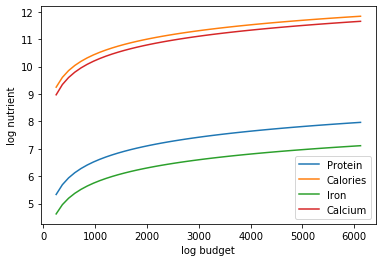

In [10]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(medianx/5,medianx*5,50).tolist()

UseNutrients = ['Protein','Calories','Iron','Calcium']

# Use reference prices
logN={}
for myx in X:
    logN[myx] = np.log(nutrient_demand(myx)[UseNutrients])
    
logN = pd.concat(logN,axis=1).T

plt.plot(X,logN)
plt.legend(UseNutrients)
plt.xlabel('log budget')
plt.ylabel('log nutrient')

Now how does nutrition vary with prices at median income?



Text(0, 0.5, 'log Nutrient')

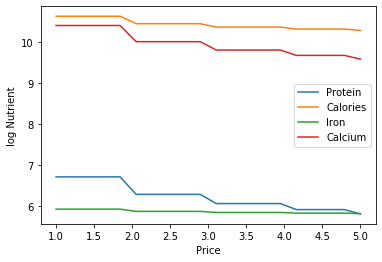

In [11]:
# Choose some good from your dataset
USE_GOOD = 'Milk'

P = np.linspace(1,5,20).tolist()

plt.plot(P,pd.concat({p0:np.log(nutrient_demand(medianx,pscale={USE_GOOD:p0})[UseNutrients]) for p0 in P},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('Price')
plt.ylabel('log Nutrient')